In [1]:
# Library import
library(Seurat)
library(ggplot2)
library(sctransform)
library(harmony)
library(patchwork)
library(dplyr)
library(magrittr)

# Multicore CPU usage activation - Future
library(future)

plan("multicore", workers = 10) 
options(future.globals.maxSize = 12000 * 1024^2)
future.seed=TRUE 

In [2]:
# Read MEX and TCR matrices
data_dir_1 <- './RhapTCRBCRdemo_SampleTag05_hs_RSEC_MolsPerCell_MEX'
data_dir_2 <- './RhapTCRBCRdemo_SampleTag06_hs_RSEC_MolsPerCell_MEX'

counts_1 <- Read10X(data.dir = data_dir_1)
counts_1_TCR <- read.table("ST 5 Clonotypes.csv", sep = ",",header = TRUE, row.names = 1) 

counts_2 <- Read10X(data.dir = data_dir_2)
counts_2_TCR <- read.table("ST 6 Clonotypes.csv", sep = ",",header = TRUE, row.names = 1)

# SeuratObject
seurat_object_1 = CreateSeuratObject(counts = counts_1$`Gene Expression`)
seurat_object_1[['ADT']] = CreateAssayObject(counts = counts_1$`Antibody Capture`)
seurat_object_1_TCR <- CreateAssayObject(counts = t(counts_1_TCR))
seurat_object_1[["TCR"]] <- seurat_object_1_TCR

seurat_object_2 = CreateSeuratObject(counts = counts_2$`Gene Expression`)
seurat_object_2[['ADT']] = CreateAssayObject(counts = counts_2$`Antibody Capture`)
seurat_object_2_TCR <- CreateAssayObject(counts = t(counts_2_TCR))
seurat_object_2[["TCR"]] <- seurat_object_2_TCR

# Calculate percent.mt
seurat_object_1[["percent.mt"]] <- PercentageFeatureSet(seurat_object_1, pattern = "^MT-")
seurat_object_2[["percent.mt"]] <- PercentageFeatureSet(seurat_object_2, pattern = "^MT-")

In [3]:
# Merge samples
merged_seurat <- merge(seurat_object_1, y = seurat_object_2, 
                       add.cell.ids = c("Sample_1",
                                        "Sample_2"), 
                       project = "TCRscape")

# Split by sample
merged_seurat[['Sample']] = as.character(sapply(
    rownames(merged_seurat@meta.data), function(x) {strsplit(x,"_")[[1]][[2]]}))
merged_seurat

An object of class Seurat 
33328 features across 6823 samples within 3 assays 
Active assay: RNA (33269 features, 0 variable features)
 2 layers present: counts.1, counts.2
 2 other assays present: ADT, TCR

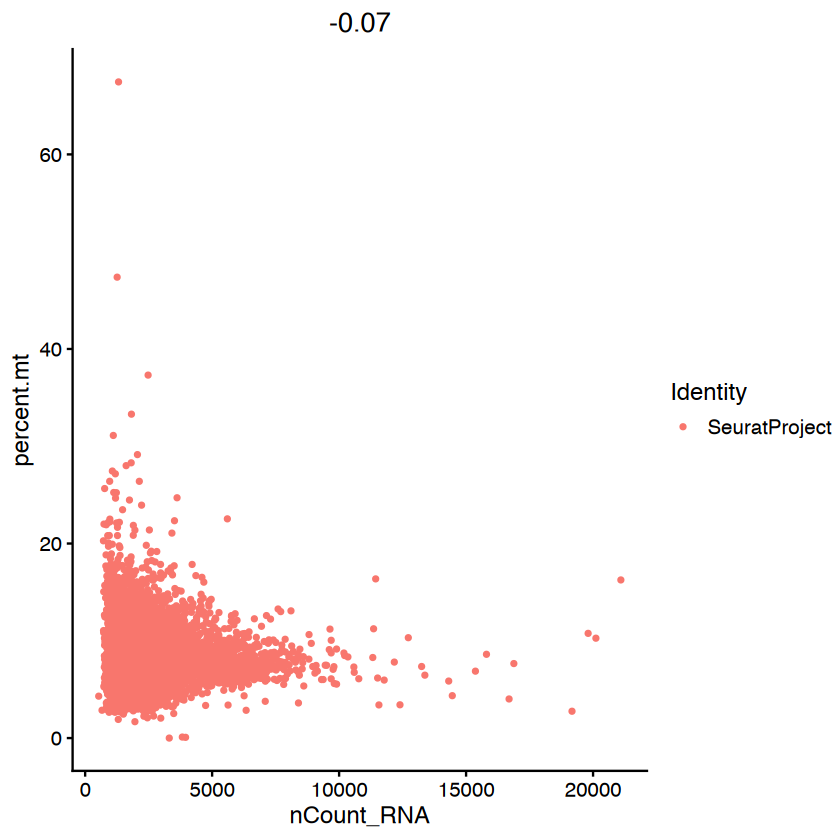

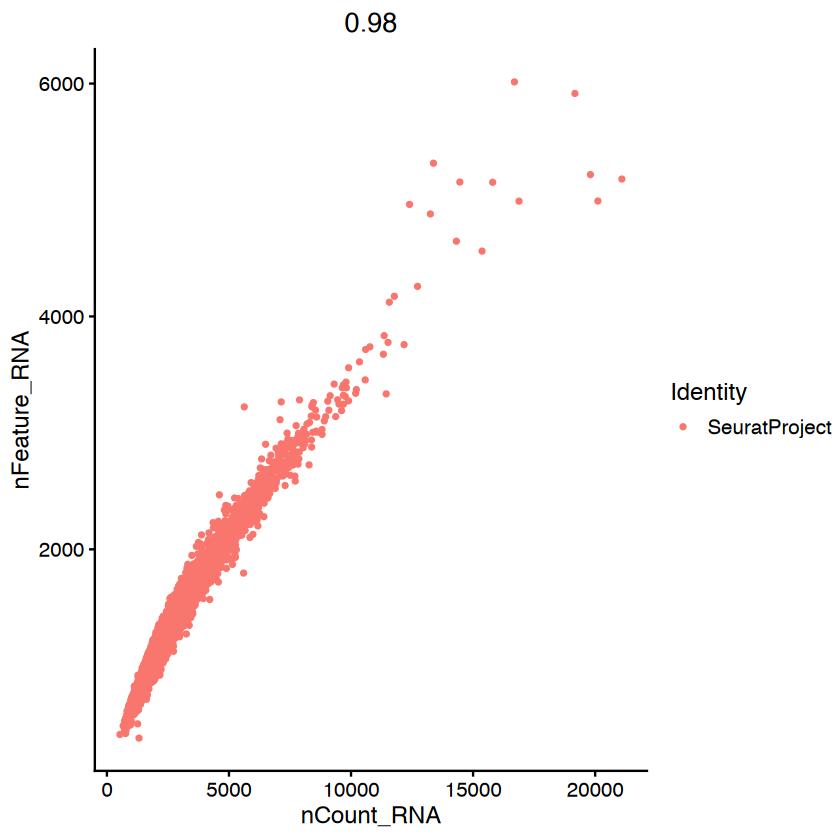

In [4]:
# FeatureScatter Plot QC

plot_QC_1 <- FeatureScatter(merged_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot_QC_2 <- FeatureScatter(merged_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot_QC_1
plot_QC_2

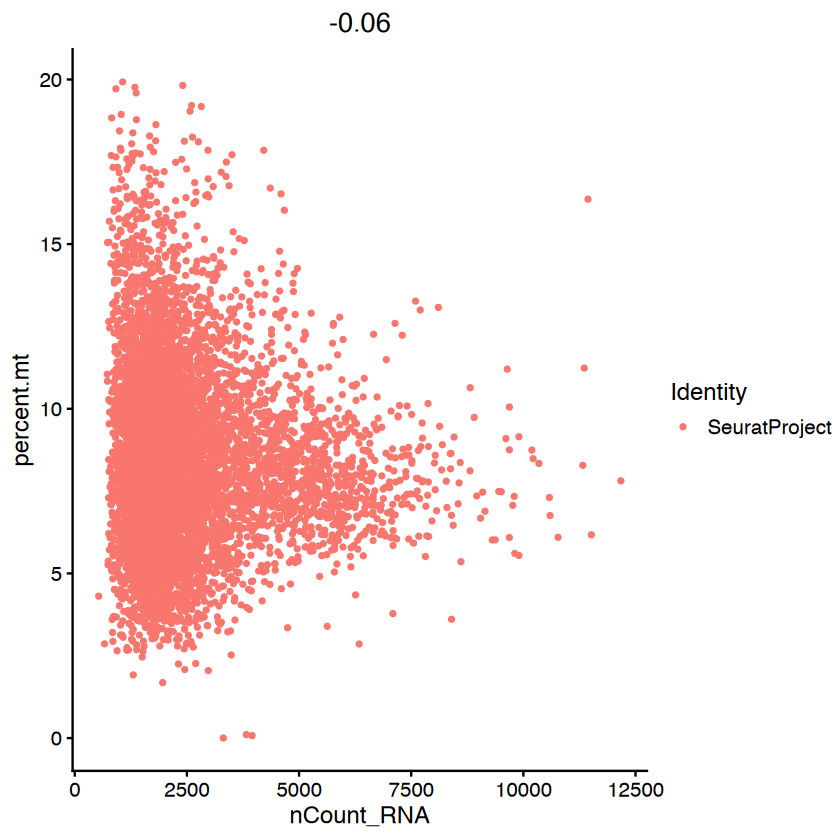

An object of class Seurat 
33328 features across 6767 samples within 3 assays 
Active assay: RNA (33269 features, 0 variable features)
 2 layers present: counts.1, counts.2
 2 other assays present: ADT, TCR

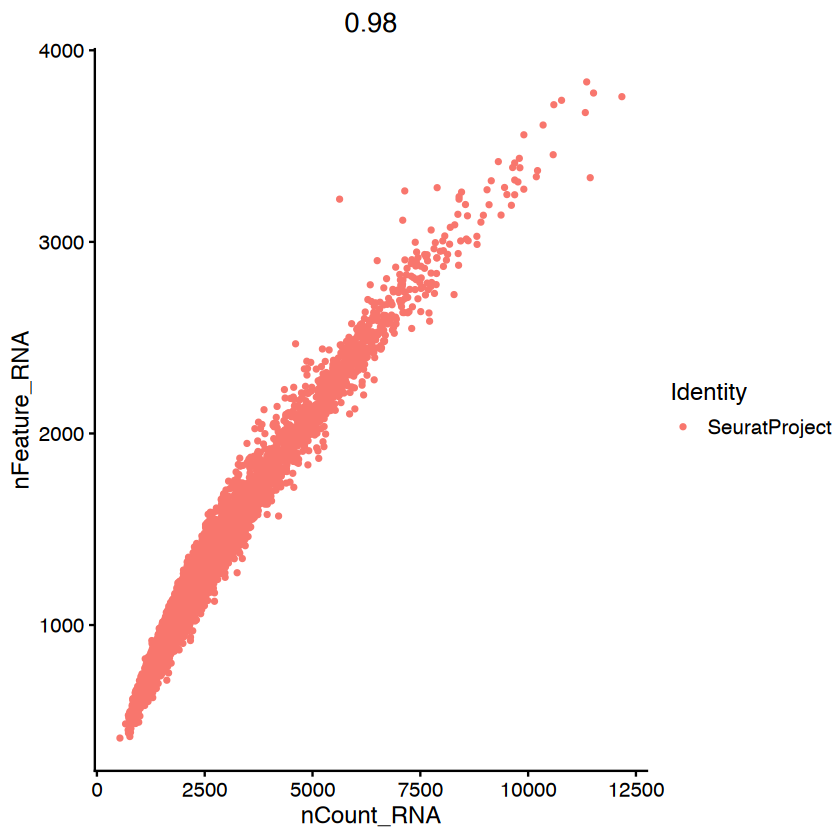

In [5]:
merged_seurat_QC <- subset(merged_seurat, subset = 
                           nFeature_RNA > 0 
                           & nFeature_RNA < 4000
                           & percent.mt < 20
                          )
plot_QC_1 <- FeatureScatter(merged_seurat_QC, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot_QC_2 <- FeatureScatter(merged_seurat_QC, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot_QC_1
plot_QC_2

In [3]:
SCT_merged_seurat <- SCTransform(merged_seurat_QC,
                                vars.to.regress = "percent.mt", 
                                 verbose = FALSE)
SCT_merged_seurat <- RunPCA(SCT_merged_seurat, npcs = 40, verbose = FALSE)

In [4]:
harmonized_seurat <- IntegrateLayers(
  object = SCT_merged_seurat,
# The following integration method functions are available:
  method = HarmonyIntegration, 
# method = CCAIntegration,
# method = JointPCAIntegration,
# method = RPCAIntegration,
  normalization.method = "SCT",
  verbose = F
)

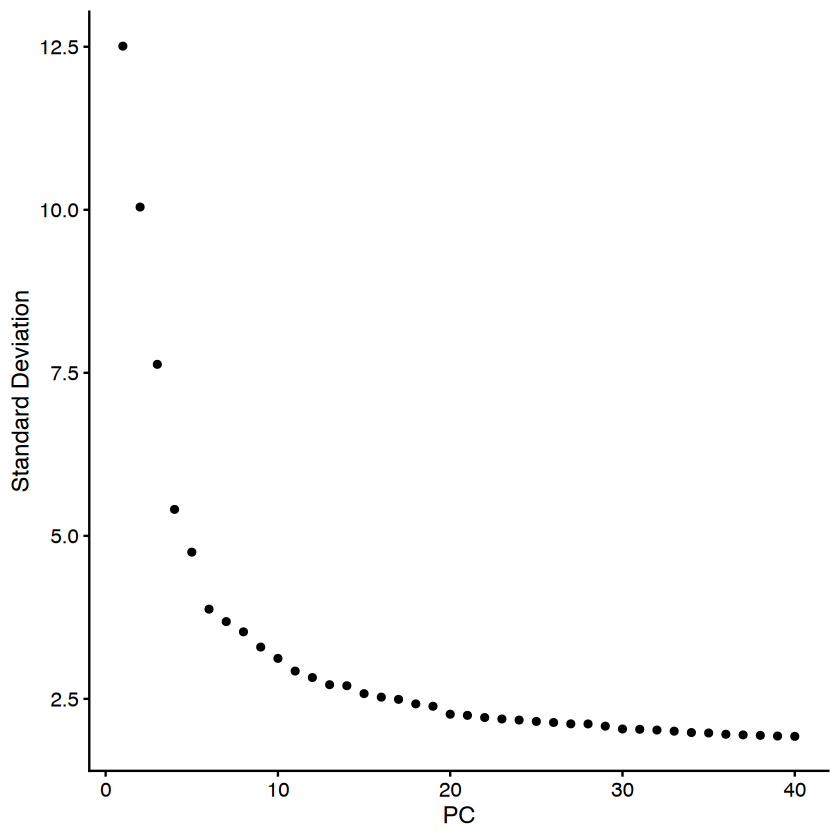

In [9]:
ElbowPlot(harmonized_seurat, ndims = 40, reduction = "pca")

In [5]:
dims = 28 

harmonized_seurat <- FindNeighbors(harmonized_seurat, dims = 1:dims, reduction = "harmony")
harmonized_seurat <- FindClusters(harmonized_seurat, resolution = 0.5)
harmonized_seurat <- RunUMAP(harmonized_seurat, dims = 1:dims, reduction = "harmony")
harmonized_seurat <- PrepSCTFindMarkers(harmonized_seurat, assay = "SCT", verbose = TRUE)

[[1]]


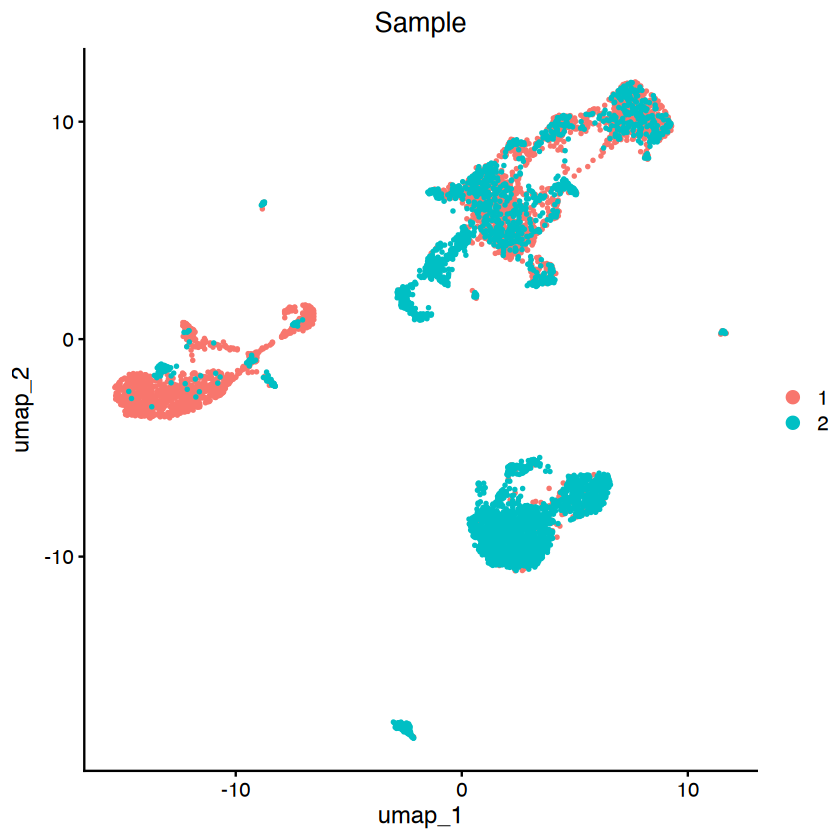

In [28]:
DimPlot(
  harmonized_seurat,
  reduction = "umap",
  group.by = c("Sample"),
  combine = FALSE, 
  pt.size = 0.5, label.size = 0.2 5
)

ggsave(
  "Cluster QC.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 16.,
  height = 15,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE
)

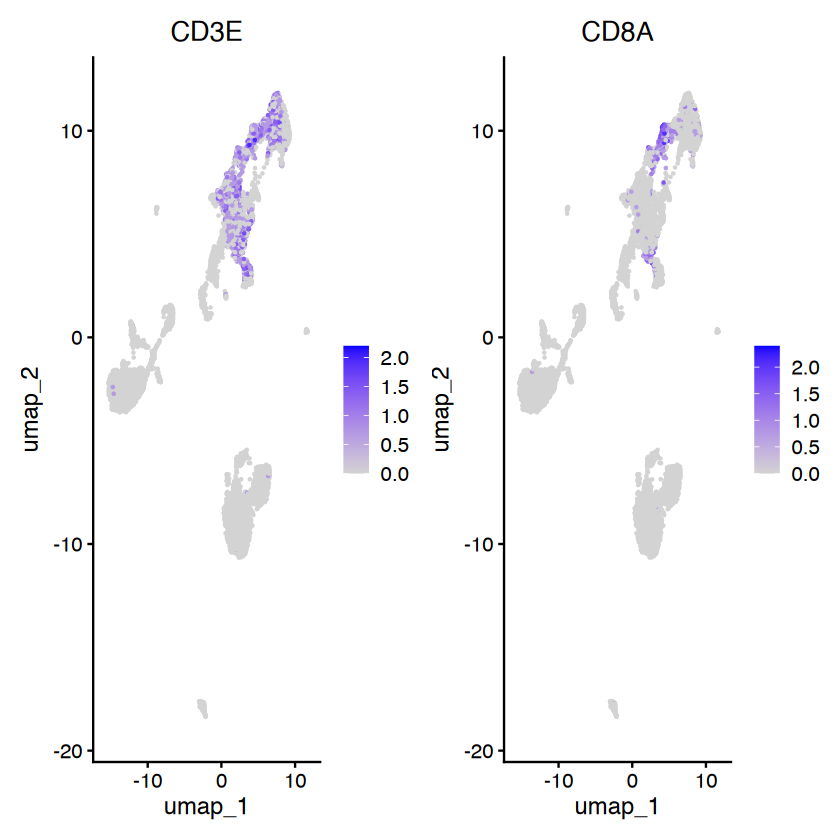

In [27]:
DefaultAssay(harmonized_seurat) <- 'SCT'
FeaturePlot(harmonized_seurat, features = c('CD3E','CD8A'), 
                  reduction = 'umap', ncol = 2, pt.size = 0.25)

ggsave(
  "T-cell Markers.pdf",
  plot = last_plot(),
  device = "pdf",
  width = 30,
  height = 15 ,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE
)

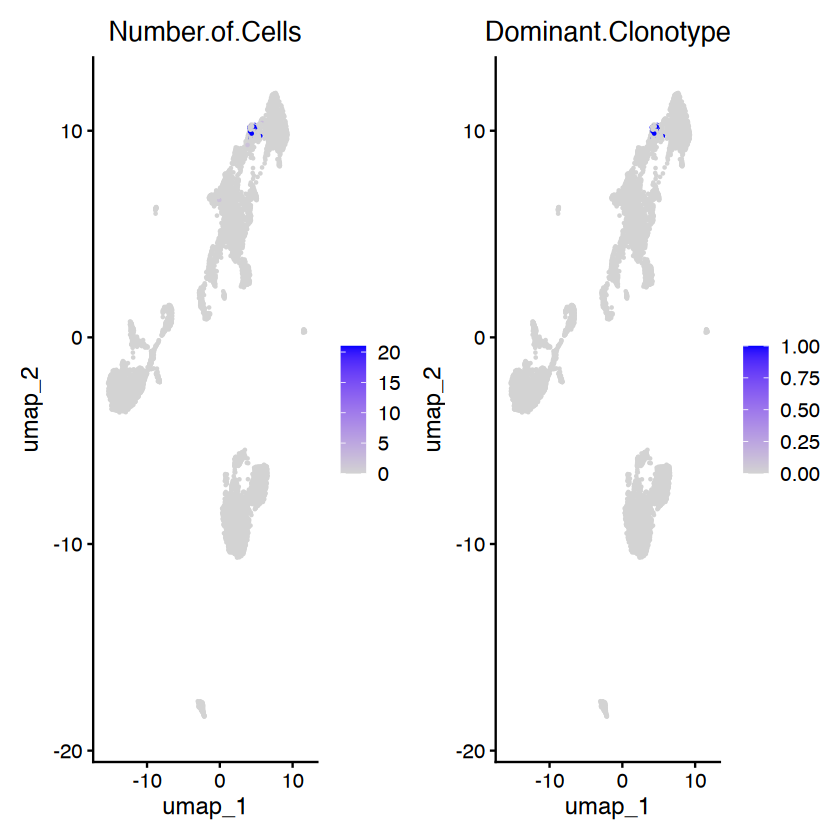

In [29]:
DefaultAssay(harmonized_seurat) <- 'TCR'
FeaturePlot(harmonized_seurat, features = c('Number.of.Cells','Dominant.Clonotype'), 
                  reduction = 'umap', ncol = 2, pt.size = 0.25)

ggsave(
  "Clonotype.pdf",
  plot = last_plot(),
  device = "pdf",
  width = 30.5 ,
  height = 15 ,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE
)